In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF" -O hw3_data.zip && rm -rf /tmp/cookies.txt
!unzip -qq hw3_data.zip -d dul_2021/Homework/hw5/data
!rm hw3_data.zip
!pip install ./dul_2021

In [2]:
from dul_2021.utils.hw5_utils import *

In [3]:
from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import matplotlib.pyplot as plt
import torch.optim as opt
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from torch.distributions.beta import Beta

import copy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from scipy.stats import norm
from scipy.optimize import bisect
from tqdm import trange, tqdm_notebook
from torch.utils import data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1: VAEs on Images
In this question, you will train VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

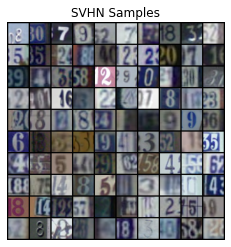

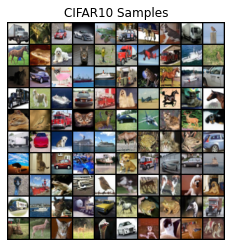

In [67]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu() 
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten()
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$ (you can compute the extra constants if you want)
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [113]:
class Encoder(nn.Module):
    def __init__(self, in_ch=3, latent_dim=16):
        super().__init__()

        self.latent_dim = latent_dim

        self.conv1 = nn.Conv2d(in_ch, 32, 3, 1, 1)

        self.conv2 = nn.Conv2d(32, 64, 3, 2, 1)   # 16 x 16

        self.conv3 = nn.Conv2d(64, 128, 3, 2, 1)  # 8 x 8

        self.conv4 = nn.Conv2d(128, 256, 3, 2, 1) # 4 x 4

        self.linear = nn.Linear(4 * 4 * 256, 2 * latent_dim)

        
    def forward(self, x):
        bs = x.shape[0]

        out = F.relu(self.conv1(x))

        out = F.relu(self.conv2(out))

        out = F.relu(self.conv3(out))

        out = F.relu(self.conv4(out))

        out = out.contiguous().view(bs, -1)

        out = self.linear(out)

        return out
        

class Decoder(nn.Module):
    def __init__(self, in_ch=3, latent_dim=16):
        super().__init__()

        self.latent_dim = latent_dim

        self.linear = nn.Linear(latent_dim, 4 * 4 * 128)

        self.t_conv1 = nn.ConvTranspose2d(128, 128, 4, 2, 1) # 8 x 8

        self.t_conv2 = nn.ConvTranspose2d(128, 64, 4, 2, 1)  # 16 x 16

        self.t_conv3 = nn.ConvTranspose2d(64, 32, 4, 2, 1)   # 32 x 32

        self.conv = nn.Conv2d(32, in_ch, 3, 1, 1)

        
    def forward(self, x):

        bs = x.shape[0]

        out = F.relu(self.linear(x))

        out = out.view(bs, 4, 4, 128)

        out = out.permute(0, 3, 1, 2) # ?

        out = F.relu(self.t_conv1(out))

        out = F.relu(self.t_conv2(out))

        out = F.relu(self.t_conv3(out))

        out = self.conv(out)

        return out       


class VAE(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.lat_dist = Normal(torch.Tensor([0.]).to(device), torch.Tensor([1.]).to(device))

    def forward(self, x):

        mu_z, log_sig_z = self.encoder(x).chunk(2, dim=1)
        z_sample = self.lat_dist.sample(mu_z.shape).squeeze(2)
        z_sample = z_sample * log_sig_z.exp() + mu_z
        z_sample = z_sample.to(device)

        mu_x = self.decoder(z_sample)

        return mu_x

    def loss(self, x):
        bs = x.shape[0]

        mu_z, log_sig_z = self.encoder(x).chunk(2, dim=1)
        z_sample = self.lat_dist.sample(mu_z.shape).squeeze(2)
        z_sample = z_sample * log_sig_z.exp() + mu_z
        z_sample = z_sample.to(device)

        mu_x = self.decoder(z_sample)
        rec_loss = (x - mu_x) ** 2  # = -c * log_prob 
        rec_loss = rec_loss.view(bs, -1).sum(1).mean()

        kl = 0.5 * ((2 * log_sig_z).exp() + mu_z ** 2) - log_sig_z - 0.5
        kl = kl.view(bs, -1).sum(1).mean()

        return rec_loss, kl


    def test(self, testloader):
        loss = 0
        tl = 0
        kl = 0
        log_prob = 0
        with torch.no_grad():
            for batch in testloader:
                batch = batch.to(device)
                lp, kl_b = self.loss(batch)
                loss += (lp + kl_b) * batch.shape[0]
                kl += kl_b * batch.shape[0]
                log_prob += lp * batch.shape[0]
                tl += batch.shape[0]
        return np.array([loss / tl, log_prob / tl, kl / tl])


    def fit(self, train_data, test_data, lr=1e-3, num_epochs=100, bs=128):
        trainloader = data.DataLoader(train_data,
                                      batch_size=bs, 
                                      shuffle=True)
        
        testloader = torch.utils.data.DataLoader(test_data, 
                                                 batch_size=bs)

        optim = opt.Adam(self.parameters(), lr=lr)
        
        train_loss = None
        test_loss = self.test(testloader)

        for epoch in range(num_epochs):
            for batch in trainloader:
                batch = batch.to(device)
                lp, kl = self.loss(batch)
                loss = lp + kl
                optim.zero_grad()
                loss.backward()
                optim.step()
                
                if train_loss is None:
                    train_loss = np.array([loss.cpu().detach().numpy(),
                                           kl.cpu().detach().numpy(),
                                           lp.cpu().detach().numpy()])
                else:
                    train_loss = np.vstack((train_loss,
                                           np.array([loss.cpu().detach().numpy(),
                                           kl.cpu().detach().numpy(),
                                           lp.cpu().detach().numpy()])))
            
            
            cur_test_loss = self.test(testloader)
            print(f'Epoch {epoch + 1}: -ELBO= {cur_test_loss[0]:.4f}, Recon Loss= {cur_test_loss[1]:.4f}, KL Loss= {cur_test_loss[2]:.4f}')
            test_loss = np.vstack((test_loss, cur_test_loss))
        
        return train_loss, test_loss


    def sample(self, n=100, noise=True):
        with torch.no_grad():
            z = self.lat_dist.sample((n, self.latent_dim)).squeeze(2)
            mu_x = self.decoder(z)
            x = mu_x
            return x.cpu().detach().numpy()


    def interpolations(self, images):
        with torch.no_grad():

            bs = images.shape[0]
            mu_z, log_sig_z = self.encoder(images).chunk(2, dim=1)
            z = self.lat_dist.sample(mu_z.shape).squeeze(2)
            z = z * log_sig_z.exp() + mu_z
            z = z.to(device)
            z1 = z[:10]
            z2 = z[10:]

            z_inter = [(z1 * (1 - phi) + z2 * phi) for phi in np.linspace(0, 1, 10)]
            z_inter = torch.cat(z_inter)

            x_inter_mu = self.decoder(z_inter)
            return x_inter_mu.cpu().detach().numpy()

In [134]:
def q1_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch

    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch

    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}

    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}

    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    # data preparing
    train_data = torch.tensor(train_data.transpose(0, 3, 1, 2))
    train_data = (train_data / 255 - 0.5) / 0.5
    test_data = torch.tensor(test_data.transpose(0, 3, 1, 2))
    test_data = (test_data / 255 - 0.5) / 0.5

    # model initialization
    vae = VAE()
    vae.to(device)
    
    # training
    train_info, test_info = vae.fit(train_data, test_data, num_epochs=20)

    # samples
    samples = vae.sample()
    samples = ((samples + 1) / 2 * 255).transpose(0, 2, 3, 1).astype(np.uint8)


    # reconstructions
    real_images_idxs = np.random.choice(np.arange(len(test_data)), size=(50,), replace=False)
    real_images_idxs = torch.tensor(real_images_idxs)
    real_images = test_data[real_images_idxs].to(device)
    reconstruct_images = vae(real_images)

    real_images = real_images.permute(0, 2, 3, 1).detach().cpu().numpy()
    reconstruct_images = reconstruct_images.permute(0, 2, 3, 1).detach().cpu().numpy()

    real_reconstruct = np.stack([real_images, reconstruct_images], axis=1)
    real_reconstruct = real_reconstruct.reshape(-1, 32, 32, 3)
    real_reconstruct = ((real_reconstruct + 1) / 2 * 255).astype(np.uint8)

    # interpolation
    real_images_idxs = np.random.choice(np.arange(len(test_data)), size=(20,), replace=False)
    real_images_idxs = torch.tensor(real_images_idxs)
    real_images = test_data[real_images_idxs].to(device)
    interpolations = vae.interpolations(real_images)
    interpolations = ((interpolations + 1) / 2 * 255).transpose(0, 2, 3, 1).astype(np.uint8)

    return train_info, test_info, samples, real_reconstruct, interpolations


### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

Epoch 1: -ELBO= 326.4973, Recon Loss= 313.9755, KL Loss= 12.5218
Epoch 2: -ELBO= 196.8376, Recon Loss= 181.3002, KL Loss= 15.5374
Epoch 3: -ELBO= 175.6214, Recon Loss= 157.7139, KL Loss= 17.9075
Epoch 4: -ELBO= 149.4973, Recon Loss= 131.2263, KL Loss= 18.2710
Epoch 5: -ELBO= 140.3418, Recon Loss= 120.1373, KL Loss= 20.2045
Epoch 6: -ELBO= 132.7587, Recon Loss= 110.6809, KL Loss= 22.0778
Epoch 7: -ELBO= 127.0749, Recon Loss= 104.2592, KL Loss= 22.8158
Epoch 8: -ELBO= 119.9634, Recon Loss= 96.0853, KL Loss= 23.8780
Epoch 9: -ELBO= 113.7990, Recon Loss= 88.8068, KL Loss= 24.9922
Epoch 10: -ELBO= 110.7940, Recon Loss= 85.3356, KL Loss= 25.4584
Epoch 11: -ELBO= 108.5207, Recon Loss= 81.5621, KL Loss= 26.9586
Epoch 12: -ELBO= 105.9559, Recon Loss= 80.8792, KL Loss= 25.0767
Epoch 13: -ELBO= 105.8893, Recon Loss= 80.4862, KL Loss= 25.4031
Epoch 14: -ELBO= 106.9949, Recon Loss= 80.8220, KL Loss= 26.1729
Epoch 15: -ELBO= 105.7125, Recon Loss= 79.2703, KL Loss= 26.4422
Epoch 16: -ELBO= 104.1923, 

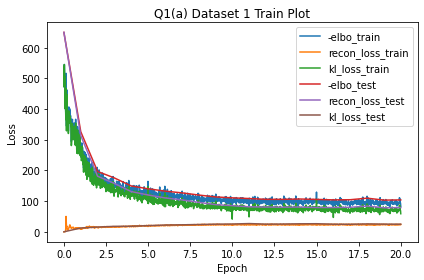

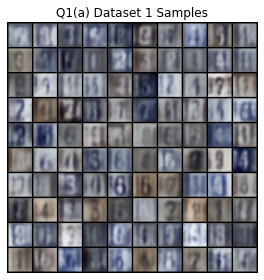

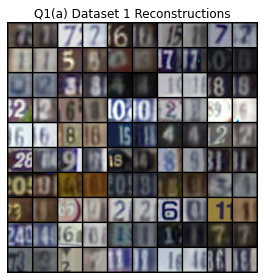

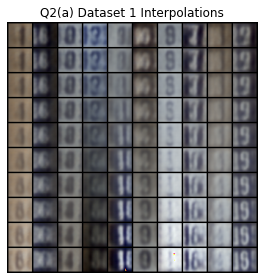

In [135]:
q1_save_results('a', 1, q1_a)

Final -ELBO: 104.0417, Recon Loss: 79.3798, KL Loss: 24.6620


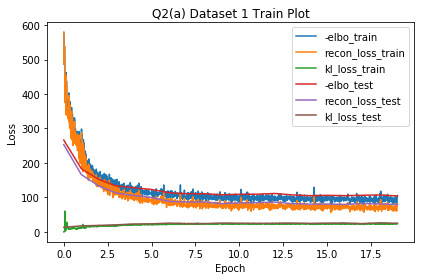

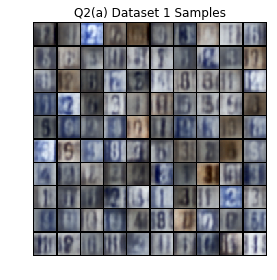

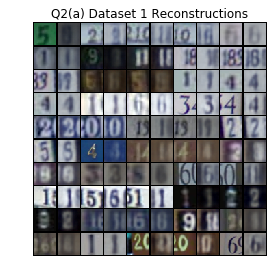

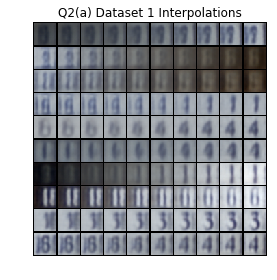

In [ ]:
q1_save_results('a', 1, q1_a) # ref

Epoch 1: -ELBO= 279.0582, Recon Loss= 248.5877, KL Loss= 30.4705
Epoch 2: -ELBO= 251.0018, Recon Loss= 221.1825, KL Loss= 29.8193
Epoch 3: -ELBO= 246.2757, Recon Loss= 216.4701, KL Loss= 29.8056
Epoch 4: -ELBO= 243.2926, Recon Loss= 213.9309, KL Loss= 29.3617
Epoch 5: -ELBO= 243.0382, Recon Loss= 211.7495, KL Loss= 31.2888
Epoch 6: -ELBO= 241.9373, Recon Loss= 212.0259, KL Loss= 29.9113
Epoch 7: -ELBO= 240.9406, Recon Loss= 210.0051, KL Loss= 30.9355
Epoch 8: -ELBO= 239.8312, Recon Loss= 209.5570, KL Loss= 30.2743
Epoch 9: -ELBO= 239.7535, Recon Loss= 209.4097, KL Loss= 30.3438
Epoch 10: -ELBO= 240.0851, Recon Loss= 210.1112, KL Loss= 29.9738
Epoch 11: -ELBO= 239.1426, Recon Loss= 208.8050, KL Loss= 30.3376
Epoch 12: -ELBO= 238.6232, Recon Loss= 207.7658, KL Loss= 30.8574
Epoch 13: -ELBO= 238.5258, Recon Loss= 207.9048, KL Loss= 30.6210
Epoch 14: -ELBO= 238.2816, Recon Loss= 208.0402, KL Loss= 30.2413
Epoch 15: -ELBO= 237.8599, Recon Loss= 207.8375, KL Loss= 30.0225
Epoch 16: -ELBO= 23

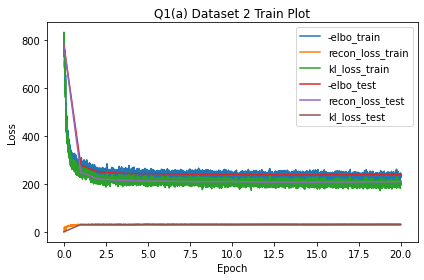

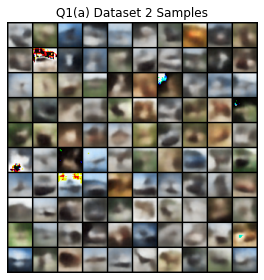

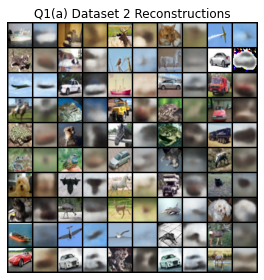

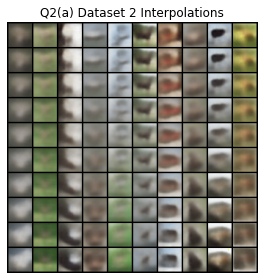

In [136]:
q1_save_results('a', 2, q1_a)